<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


last updated: 2017-05-23 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
matplotlib 2.0.1
scipy 0.19.0
pandas 0.19.2
sklearn 0.18.1
mlxtend 0.6.0


In [2]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from sklearn.metrics import accuracy_score

import comptools as comp
import comptools.analysis.plotting as plotting
    
color_dict = comp.analysis.get_color_dict()

/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
# config = 'IC79'
config = 'IC86.2012'
comp_list = ['light', 'heavy']
pipeline_str = 'GBDT'
feature_list, feature_labels = comp.get_training_features()

In [6]:
sim_df_train, sim_df_test = comp.load_dataframe(datatype='sim', config=config)
pipeline = comp.get_pipeline(pipeline_str)

TypeError: Expecting a DataFrame, but got <type 'NoneType'>

In [6]:
light_mask = sim_df_train['MC_comp_class'] == 'light'
heavy_mask = sim_df_train['MC_comp_class'] == 'heavy'
null_mask = ~sim_df_train['refit_beta'].isnull()
energy_mask = (sim_df_train['log_s125'] > 1.5) & (sim_df_train['log_s125'] <= 1.75)
zenith_mask = (sim_df_train['lap_cos_zenith'] > 0.9) & (sim_df_train['lap_cos_zenith'] <= 1.0)
radius_mask = (sim_df_train['avg_inice_radius'] > 120) & (sim_df_train['avg_inice_radius'] <= 130)

In [35]:
data_df = comp.load_dataframe(datatype='data', config=config, split=False)

Starting out with 8020592 events
data quality cut event flow:
      passed_IceTopQualityCuts:    1.0    1.0
FractionContainment_Laputop_InIce:    1.0    1.0
       passed_InIceQualityCuts:  0.918  0.918
                 num_hits_1_60:    1.0  0.918




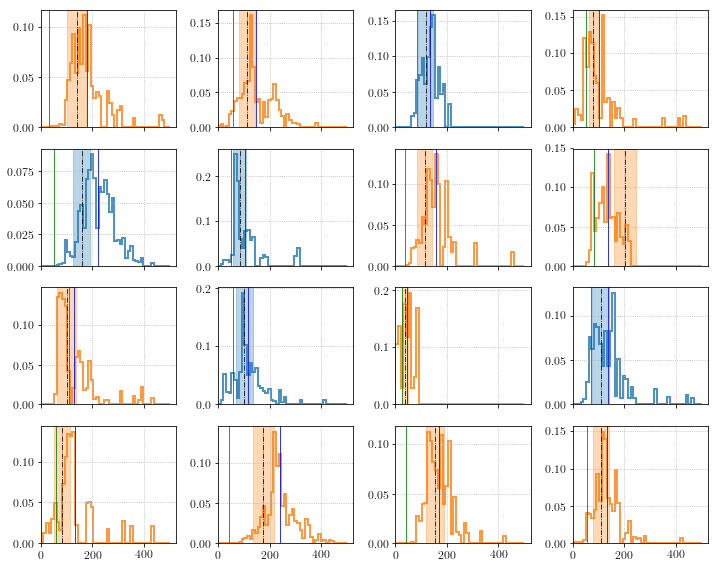

In [24]:
n_side = 4
fig, axarr = plt.subplots(n_side, n_side, figsize=(10, 8), sharex=True, sharey=False)
dist_bins = np.linspace(0, 500, 50)
for idx, ax in zip(range(n_side**2), axarr.flatten()):
    row = sim_df_train.iloc[idx]
    charges = row['inice_dom_charges_1_60']
    dists = row['inice_dom_dists_1_60']
    avg_dist = row['avg_inice_radius']
    std_dist = row['std_inice_radius']
    color = color_dict[row['MC_comp_class']]
#     ax.hist(dists, bins=dist_bins, weights=None, histtype='step', lw=2,
#             alpha=0.8, color=color)

    charge_weights = charges/charges.sum()
    charge_weighed_avg = np.average(dists, weights=charge_weights)
    ax.axvline(charge_weighed_avg, marker='None', ls='-', c='g')
#     ax.hist(dists, bins=dist_bins, weights=charges/charges.sum(), histtype='step', lw=2,
#             alpha=0.8, color=color)

    inv_charge_weights = (1/charges)/(1/charges).sum()
    inv_charge_weighed_avg = np.average(dists, weights=inv_charge_weights)
    ax.axvline(inv_charge_weighed_avg, marker='None', ls='-', c='b')
    ax.hist(dists, bins=dist_bins, weights=inv_charge_weights, histtype='step', lw=2,
            alpha=0.8, color=color)
    
#     n_channels = len(dists)
#     ax.hist(dists, bins=dist_bins, weights=[1/n_channels]*n_channels, histtype='step', lw=2,
#             alpha=0.8, color=color)
    ax.axvline(avg_dist, marker='None', ls='-.', c='k')
    ax.axvspan(avg_dist-0.5*std_dist, avg_dist+0.5*std_dist, alpha=0.3, color=color)
    ax.grid()
    ax.set_xlim(0)
plt.legend()
plt.show()

In [40]:
def calc_weighted_dist_diff(row):
    charges = row['inice_dom_charges_1_60']
    dists = row['inice_dom_dists_1_60']
    avg_dist = row['avg_inice_radius']

    charge_weights = charges/np.sum(charges)
    charge_weighed_avg = np.average(dists, weights=charge_weights)
    
    inv_charge_weights = (1/charges)/np.sum((1/charges))
    inv_charge_weighed_avg = np.average(dists, weights=inv_charge_weights)

    return inv_charge_weighed_avg-avg_dist

In [41]:
sim_df_train['weighted_dist_diff'] = sim_df_train.apply(calc_weighted_dist_diff, axis=1)

/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
sim_df_train = sim_df_train[~sim_df_train.weighted_dist_diff.isnull()]

/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


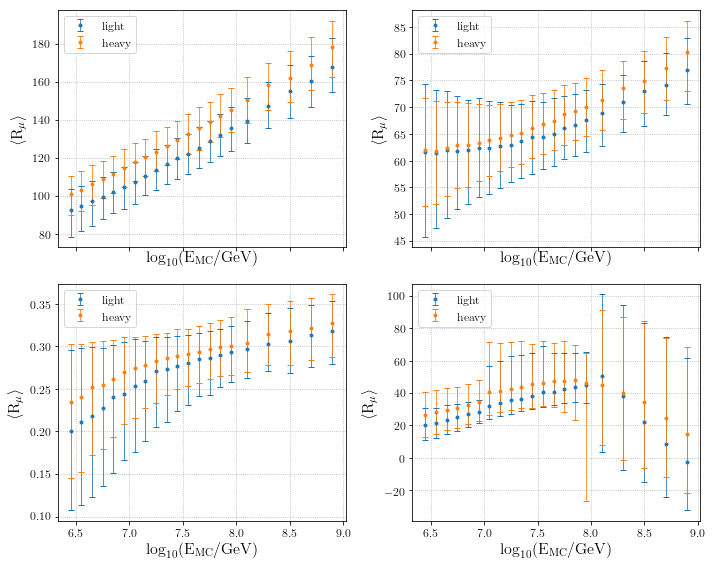

In [43]:
energybins = comp.analysis.get_energybins()
fig, axarr = plt.subplots(2, 2, sharex=True, figsize=(10, 8))
keys = ['avg_inice_radius', 'std_inice_radius',
        'frac_outside_one-std_inice_radius',
        'weighted_dist_diff']
for key, ax in zip(keys, axarr.flatten()):
    bin_centers, bin_medians_light, error_light = comp.analysis.get_medians(sim_df_train[light_mask].MC_log_energy.values,
                                                                sim_df_train[light_mask][key].values,
                                                                energybins.log_energy_bins)
    bin_centers, bin_medians_heavy, error_heavy = comp.analysis.get_medians(sim_df_train[heavy_mask].MC_log_energy.values,
                                                                sim_df_train[heavy_mask][key].values,
                                                                energybins.log_energy_bins)

    ax.errorbar(bin_centers, bin_medians_light, yerr=error_light, label='light', ls='None', marker='.')
    ax.errorbar(bin_centers, bin_medians_heavy, yerr=error_heavy, label='heavy', ls='None', marker='.')
    ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
    ax.set_ylabel('$\mathrm{\\langle R_{\mu} \\rangle}$')
    ax.grid()
    ax.legend()
plt.show()

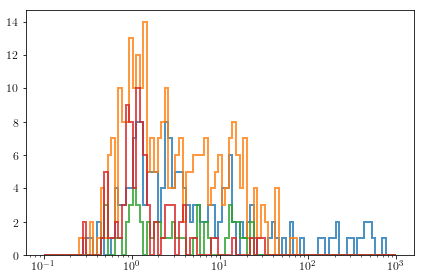

In [16]:
fig, ax = plt.subplots()
charge_bins = np.logspace(-1, 3, 100)
for idx, dists in sim_df_train.inice_dom_charges_1_60.iteritems():
    if idx >= 4: break
    ax.hist(dists, bins=charge_bins, histtype='step', lw=2, alpha=0.8)
    ax.set_xscale("log", nonposx='clip')
plt.show()

In [59]:
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 2)
        
fig, ax = plt.subplots(2, 2)
for idx, row, ax in imerge(sim_df_train[['tanks_charge_Laputop', 'tanks_dist_Laputop']].iterrows(), ):
    if idx >= 4: break
    charges = row['tanks_charge_Laputop']
    dists = row['tanks_dist_Laputop']
    is_null_mask = np.isnan(charges) & np.isnan(dists)
    dist_bins = np.linspace(0, 1e3, 50)
    ax.hist(dists[~is_null_mask], bins=dist_bins, weights=(1/charges)[~is_null_mask],
            histtype='step', lw=2, alpha=0.8)
    ax.set_yscale("log", nonposx='clip')
plt.show()

TypeError: 'int' object is not iterable

KeyError: 'tanks_dist_Laputop'

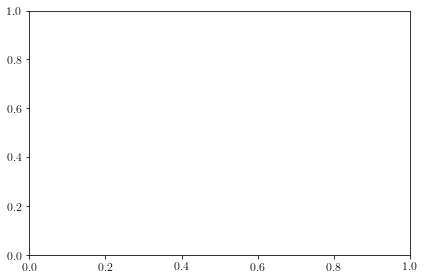

In [32]:
sim_df_train.plot(x='tanks_dist_Laputop', y='tanks_charge_Laputop', kind='hexbin')

<IPython.core.display.Javascript object>


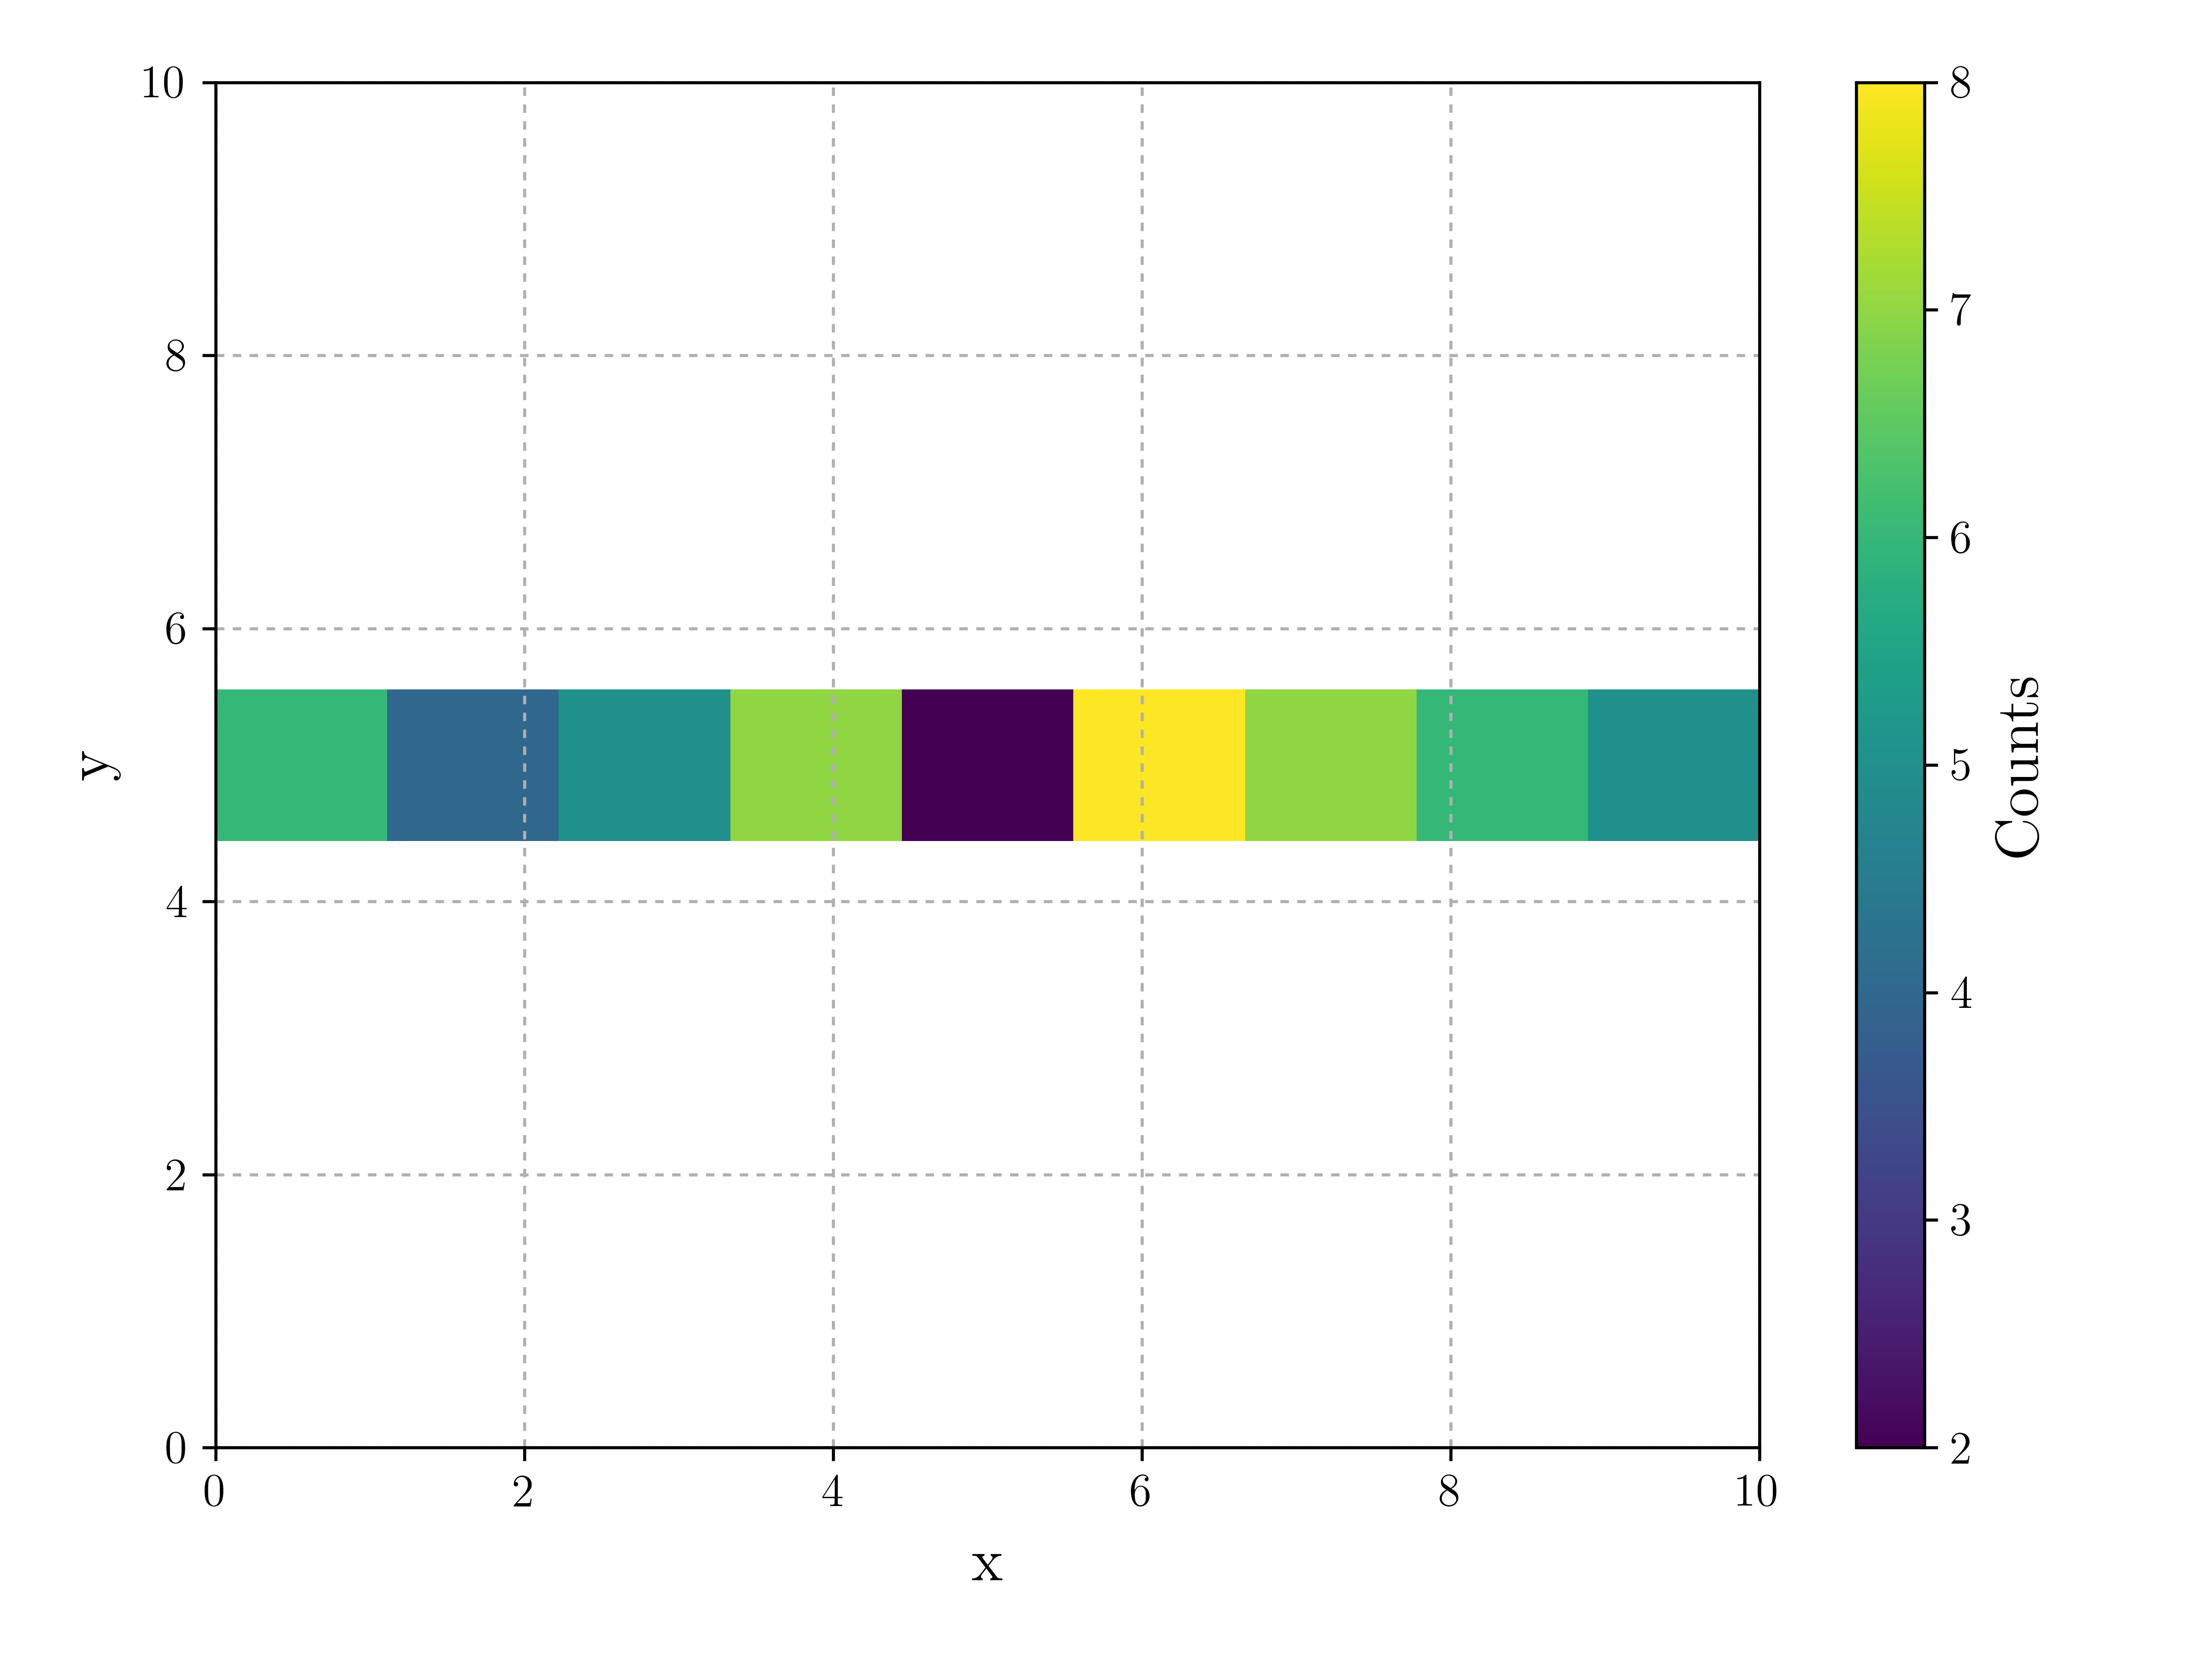

In [10]:
fig, ax = plt.subplots()
plotting.histogram_2D(10*np.random.rand(50), [5]*50, bins=np.linspace(0, 10, 10), ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
plt.show()

In [8]:
10*np.random.rand(10)

array([ 6.28203225,  0.82388727,  7.55179687,  2.37605409,  7.89232788,
        5.61421721,  6.15359468,  9.85702861,  8.68099857,  8.01995606])

In [ ]:
energybins = comp.analysis.get_energybins()
fig, ax = plt.subplots()
bin_centers, bin_medians_light, error_light = comp.analysis.get_medians(df_sim[light_mask].MC_log_energy.values,
                                                            df_sim[light_mask]['log_IceTop_charge_175m'],
                                                            energybins.log_energy_bins)
print(df_sim[light_mask].avg_inice_radius_1_30.values)

bin_centers, bin_medians_heavy, error_heavy = comp.analysis.get_medians(df_sim[heavy_mask].MC_log_energy.values,
                                                            df_sim[heavy_mask]['log_IceTop_charge_175m'],
                                                            energybins.log_energy_bins)
print(df_sim[heavy_mask].avg_inice_radius_1_30.values)

ax.errorbar(bin_centers, bin_medians_light, yerr=error_light, label='light', ls='None', marker='.')
ax.errorbar(bin_centers, bin_medians_heavy, yerr=error_heavy, label='heavy', ls='None', marker='.')
ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(Q_{IT})}$')
ax.set_title('Tank distance $\mathrm{> 175 \ m}$')
ax.grid()
ax.legend()
plt.savefig('/home/jbourbeau/public_html/figures/IceTop_charge_175m-vs-energy.png')
plt.show()

<IPython.core.display.Javascript object>


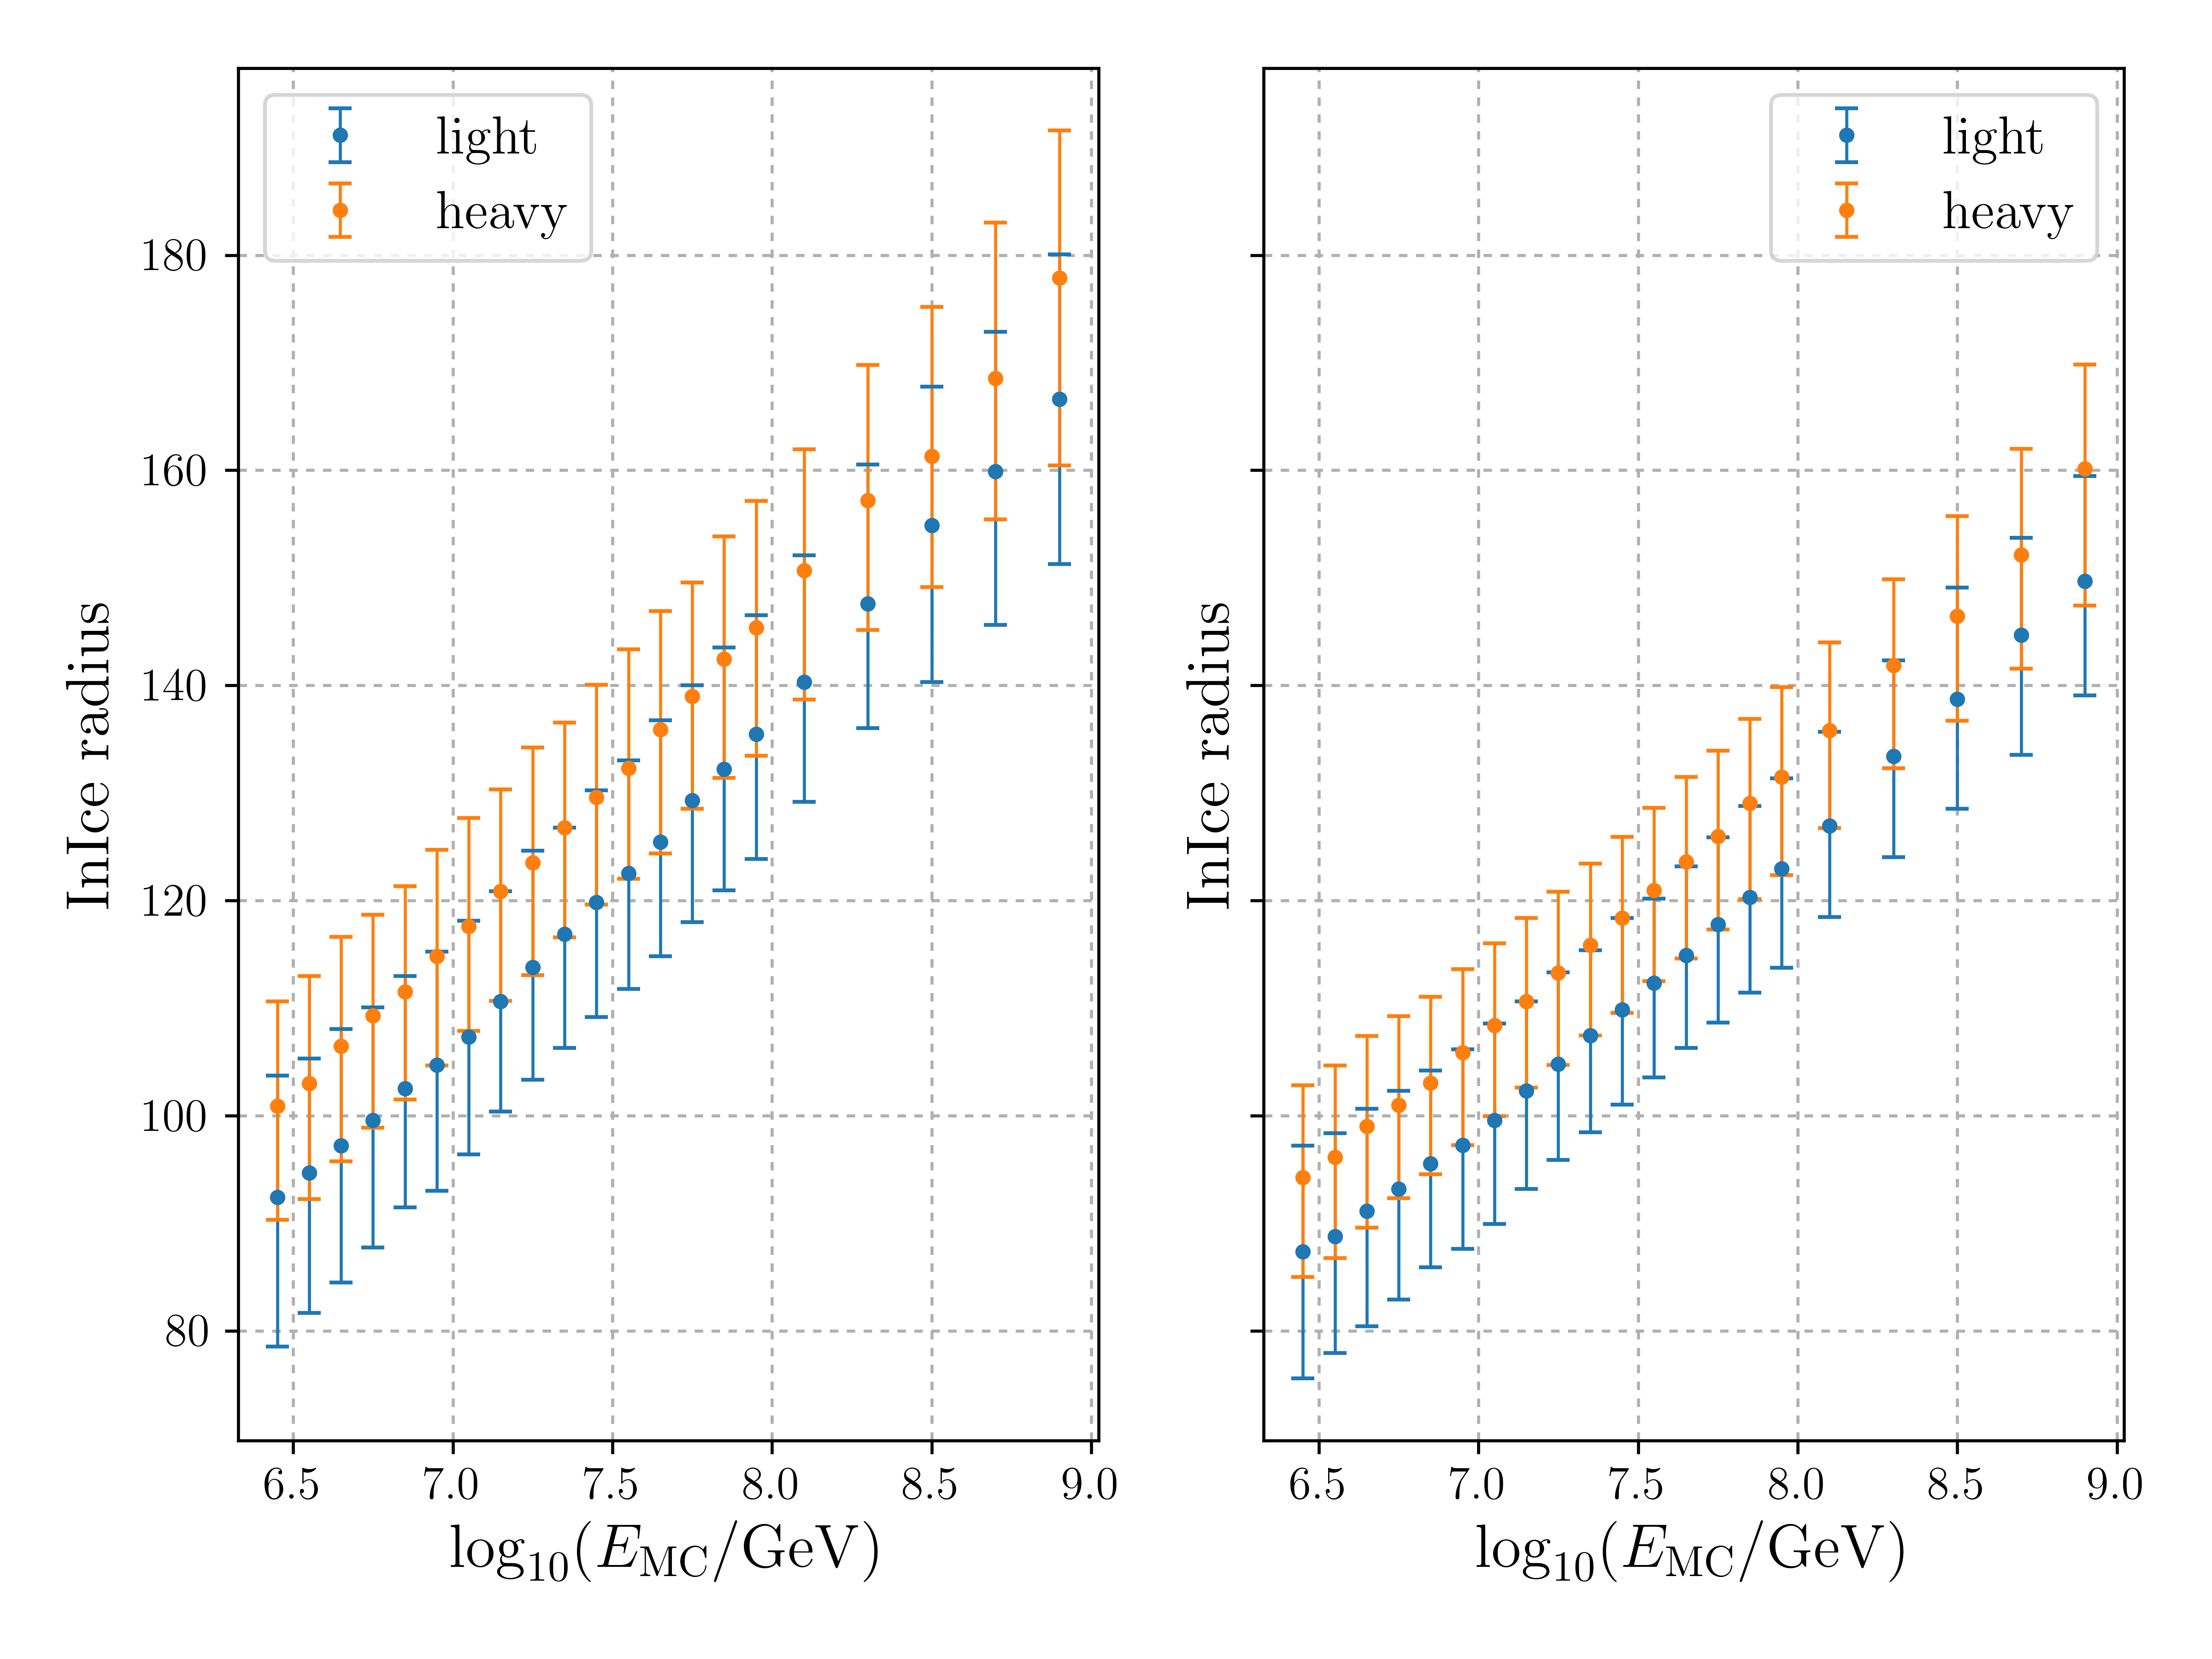

[  87.13774878   90.15561286   78.94222433 ...,  124.095852     77.75987213
   77.26672742]
[ 107.07188445  111.48396849  104.21450775 ...,  130.50329063  129.48606006
  131.06563202]
[  82.99618806   85.48093552   72.53942722 ...,  112.27001365   79.40478295
   76.23483925]
[ 100.32557283  108.69898595   97.13398243 ...,  118.82006015  114.18453454
  115.63854243]


In [11]:
energybins = comp.analysis.get_energybins()
fig, axarr = plt.subplots(1, 2, sharex=True, sharey=True)
for key, ax in zip(['avg_inice_radius_1_60', 'avg_inice_radius_1_30'], axarr.flatten()):
    bin_centers, bin_medians_light, error_light = comp.analysis.get_medians(df_sim[light_mask].MC_log_energy.values,
                                                                df_sim[light_mask][key],
                                                                energybins.log_energy_bins)
    print(df_sim[light_mask][key].values)

    bin_centers, bin_medians_heavy, error_heavy = comp.analysis.get_medians(df_sim[heavy_mask].MC_log_energy.values,
                                                                df_sim[heavy_mask][key],
                                                                energybins.log_energy_bins)
    print(df_sim[heavy_mask][key].values)

    ax.errorbar(bin_centers, bin_medians_light, yerr=error_light, label='light', ls='None', marker='.')
    ax.errorbar(bin_centers, bin_medians_heavy, yerr=error_heavy, label='heavy', ls='None', marker='.')
    ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
    ax.set_ylabel('InIce radius')
    ax.grid()
    ax.legend()
plt.show()

<IPython.core.display.Javascript object>


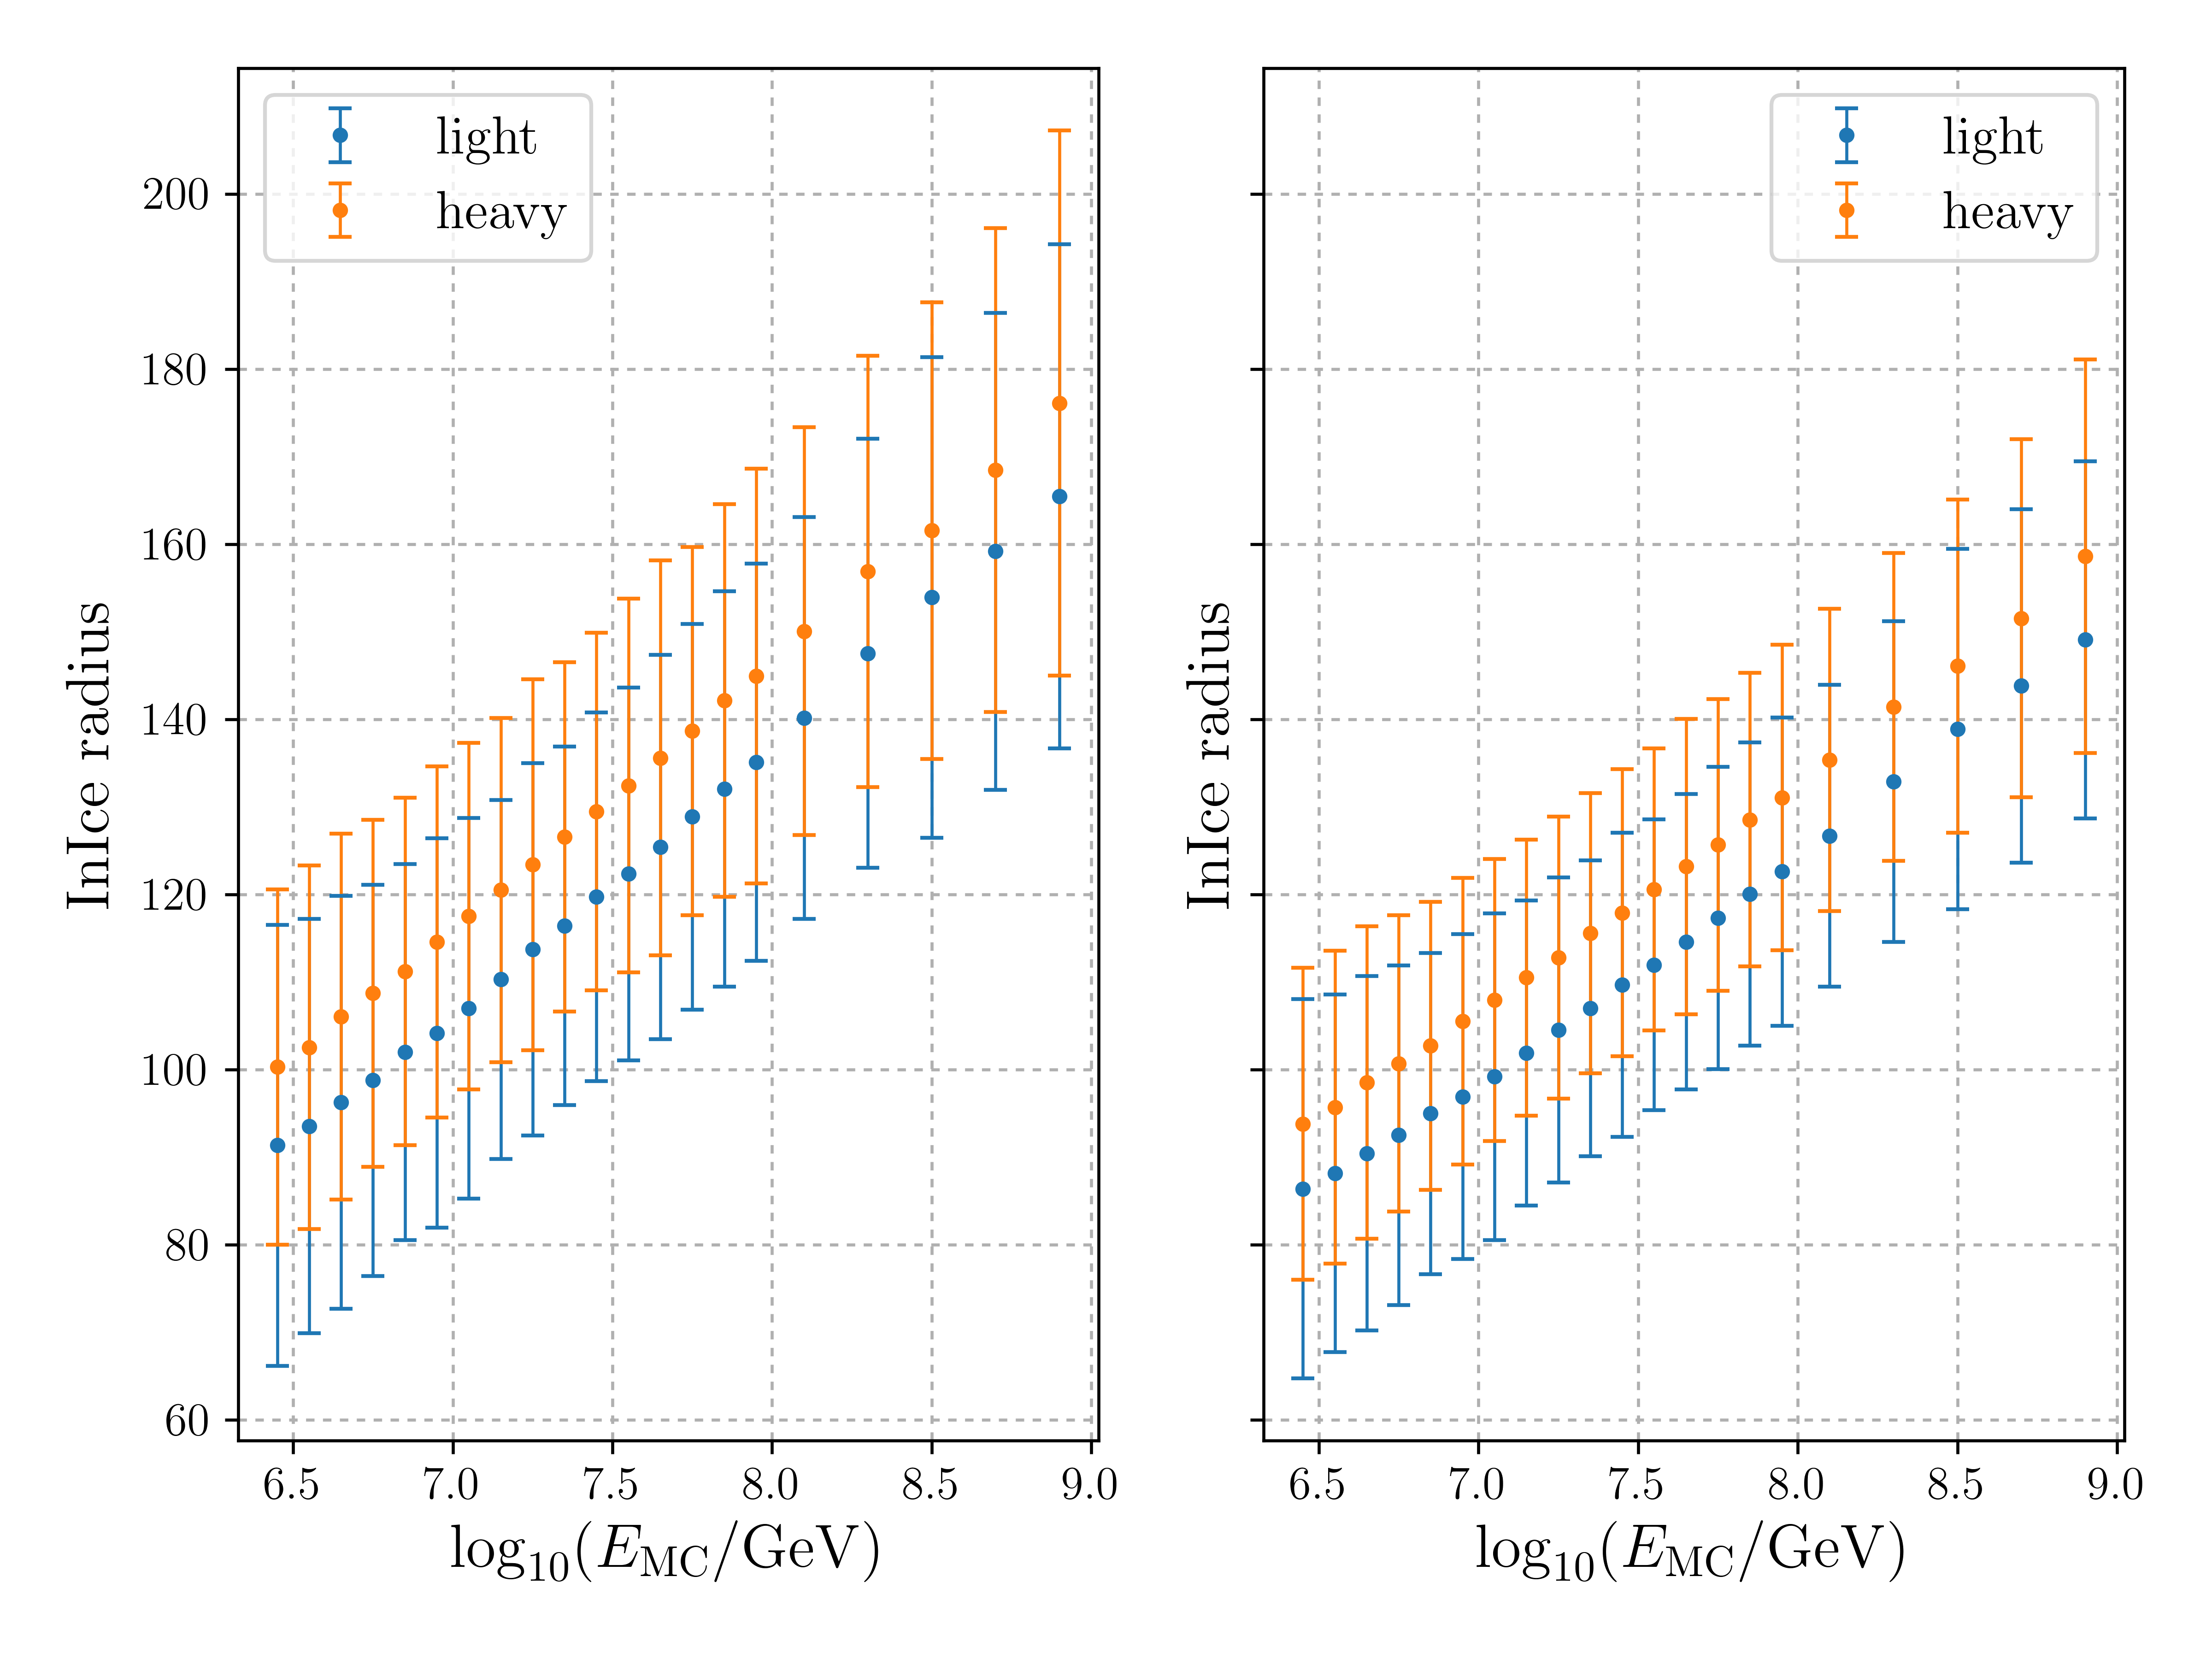

[  87.13774878   90.15561286   78.94222433 ...,  124.095852     77.75987213
   77.26672742]
[ 107.07188445  111.48396849  104.21450775 ...,  130.50329063  129.48606006
  131.06563202]
[  82.99618806   85.48093552   72.53942722 ...,  112.27001365   79.40478295
   76.23483925]
[ 100.32557283  108.69898595   97.13398243 ...,  118.82006015  114.18453454
  115.63854243]


In [9]:
energybins = comp.analysis.get_energybins()
fig, axarr = plt.subplots(1, 2, sharex=True, sharey=True)
for key, ax in zip(['avg_inice_radius_1_60', 'avg_inice_radius_1_30'], axarr.flatten()):
    avg_light, std_light, bin_edges = comp.analysis.get_avg_std(df_sim[light_mask].MC_log_energy.values,
                                                                df_sim[light_mask][key],
                                                                energybins.log_energy_bins)
    print(df_sim[light_mask][key].values)

    avg_heavy, std_heavy, bin_edges = comp.analysis.get_avg_std(df_sim[heavy_mask].MC_log_energy.values,
                                                                df_sim[heavy_mask][key],
                                                                energybins.log_energy_bins)
    print(df_sim[heavy_mask][key].values)

    ax.errorbar(bin_centers, avg_light, yerr=std_light, label='light', ls='None', marker='.')
    ax.errorbar(bin_centers, avg_heavy, yerr=std_heavy, label='heavy', ls='None', marker='.')
    ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
    ax.set_ylabel('InIce radius')
    ax.grid()
    ax.legend()
plt.show()

In [24]:
np.sum(null_mask)/len(df_sim)

0.043667241907649632

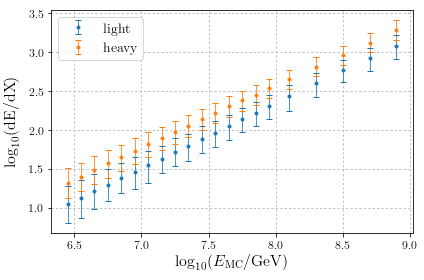

In [11]:
energybins = comp.analysis.get_energybins()
fig, ax = plt.subplots()
light_mask = df_sim['MC_comp_class'] == 'light'
bin_centers, bin_medians_light, error_light = comp.analysis.get_medians(df_sim[light_mask].MC_log_energy.values,
                                                            df_sim[light_mask].log_dEdX.values,
                                                            energybins.log_energy_bins)
heavy_mask = df_sim['MC_comp_class'] == 'heavy'
bin_centers, bin_medians_heavy, error_heavy = comp.analysis.get_medians(df_sim[heavy_mask].MC_log_energy.values,
                                                            df_sim[heavy_mask].log_dEdX.values,
                                                            energybins.log_energy_bins)

ax.errorbar(bin_centers, bin_medians_light, yerr=error_light, label='light', ls='None', marker='.')
ax.errorbar(bin_centers, bin_medians_heavy, yerr=error_heavy, label='heavy', ls='None', marker='.')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.set_ylabel('$\log_{10}(\mathrm{dE/dX})$')
ax.grid()
ax.legend()
plt.show()

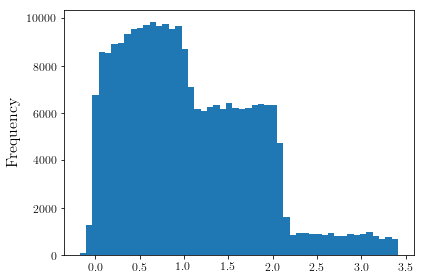

In [5]:
df_sim.log_s125.plot(kind='hist', bins=50)

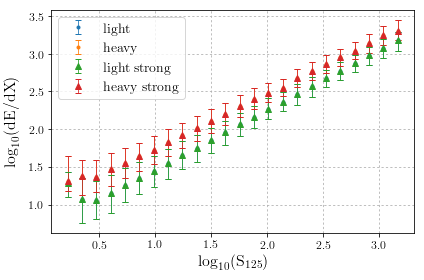

In [6]:
s125_bins = np.linspace(-1, 4, 40)
fig, ax = plt.subplots()
light_mask = (df_sim['MC_comp_class'] == 'light') & (df_sim['lap_log_energy'] > 6.4) & (df_sim['lap_log_energy'] < 9.0)
bin_centers, bin_medians_light, error_light = comp.analysis.get_medians(df_sim[light_mask].log_s125.values,
                                                            df_sim[light_mask].log_dEdX.values,
                                                            s125_bins)
heavy_mask = (df_sim['MC_comp_class'] == 'heavy') & (df_sim['lap_log_energy'] > 6.4) & (df_sim['lap_log_energy'] < 9.0)
bin_centers, bin_medians_heavy, error_heavy = comp.analysis.get_medians(df_sim[heavy_mask].log_s125.values,
                                                            df_sim[heavy_mask].log_dEdX.values,
                                                            s125_bins)

ax.errorbar(bin_centers, bin_medians_light, yerr=error_light, label='light', ls='None', marker='.')
ax.errorbar(bin_centers, bin_medians_heavy, yerr=error_heavy, label='heavy', ls='None', marker='.')


bin_centers, bin_medians_light, error_light = comp.analysis.get_medians(df_sim[light_mask].log_s125.values,
                                                            df_sim[light_mask].log_dEdX_strong.values,
                                                            s125_bins)
bin_centers, bin_medians_heavy, error_heavy = comp.analysis.get_medians(df_sim[heavy_mask].log_s125.values,
                                                            df_sim[heavy_mask].log_dEdX_strong.values,
                                                            s125_bins)

ax.errorbar(bin_centers, bin_medians_light, yerr=error_light, label='light strong', ls='None', marker='^')
ax.errorbar(bin_centers, bin_medians_heavy, yerr=error_heavy, label='heavy strong', ls='None', marker='^')


ax.set_xlabel('$\log_{10}(\mathrm{S_{125}})$')
ax.set_ylabel('$\log_{10}(\mathrm{dE/dX})$')
ax.grid()
ax.legend()
plt.savefig('/home/jbourbeau/public_html/figures/energyloss-vs-s125-dist.png')
plt.show()

NameError: name 'df_sim' is not defined

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


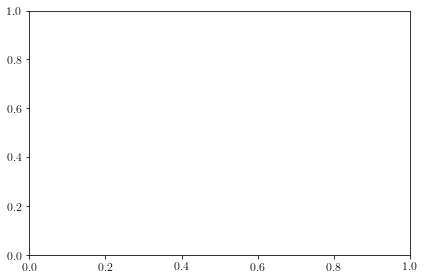

In [9]:
s125_bins = np.linspace(1.25, 2.75, 75)

fig, ax = plt.subplots()

# df_sim['log_dEdX'][light_mask & energy_mask].plot(kind='hist', bins=bins, alpha=0.75, label='light', ax=ax)
# df_sim['log_dEdX'][heavy_mask & energy_mask].plot(kind='hist', bins=bins, alpha=0.75, label='heavy', ax=ax)

light_counts = np.histogram(df_sim['log_dEdX'][light_mask & energy_mask], s125_bins)[0]
heavy_counts = np.histogram(df_sim['log_dEdX'][heavy_mask & energy_mask], s125_bins)[0]

plotting.plot_steps(s125_bins, light_counts, yerr=np.sqrt(light_counts), ax=ax, color='C0', label='light')
plotting.plot_steps(s125_bins, heavy_counts, yerr=np.sqrt(heavy_counts), ax=ax, color='C1', label='heavy')

# ax.set_yscale("log", nonposy='clip')
ax.set_ylabel('Counts')
ax.set_xlabel('$\mathrm{\\log_{10}(dE/dX)}$')
ax.set_title('$\mathrm{ 7.5 < \\log_{10}(E_{reco}/GeV) < 7.6 }$')
ax.set_xlim([1.25, 2.75])
ax.set_ylim(0)
ax.grid()
ax.legend(title='True composition')
plt.savefig('/home/jbourbeau/public_html/figures/dEdX-dist-example.png')
plt.show()

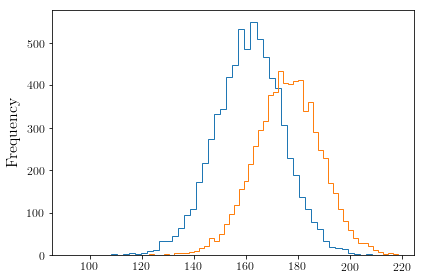

In [26]:
fig, ax = plt.subplots()
sim_train_df[light_mask & energy_mask & zenith_mask].invqweighted_inice_radius_1_60.plot(kind='hist', bins=50, ax=ax, histtype='step')
sim_train_df[heavy_mask & energy_mask & zenith_mask].invqweighted_inice_radius_1_60.plot(kind='hist', bins=50, ax=ax, histtype='step')
plt.show()

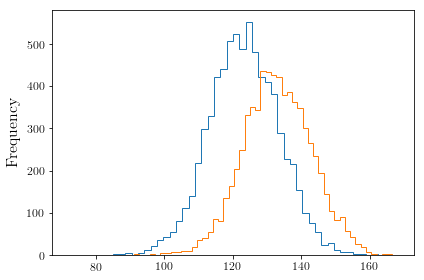

In [27]:
fig, ax = plt.subplots()
sim_train_df[light_mask & energy_mask & zenith_mask].avg_inice_radius_1_60.plot(kind='hist', bins=50, ax=ax, histtype='step')
sim_train_df[heavy_mask & energy_mask & zenith_mask].avg_inice_radius_1_60.plot(kind='hist', bins=50, ax=ax, histtype='step')
plt.show()

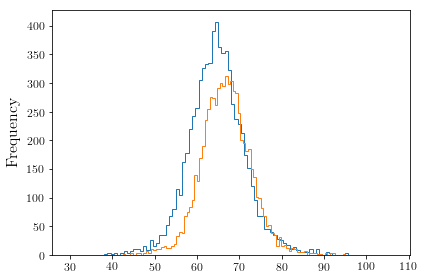

In [23]:
fig, ax = plt.subplots()
sim_train_df[light_mask & energy_mask & zenith_mask].std_inice_radius_1_60.plot(kind='hist', bins=100, ax=ax, histtype='step')
sim_train_df[heavy_mask & energy_mask & zenith_mask].std_inice_radius_1_60.plot(kind='hist', bins=100, ax=ax, histtype='step')
plt.show()

In [9]:
feature_dict =  {'log_s125': 1.625, 'lap_cos_zenith': 0.95}

ValueError: Both xkey and ykey must be in data.columns

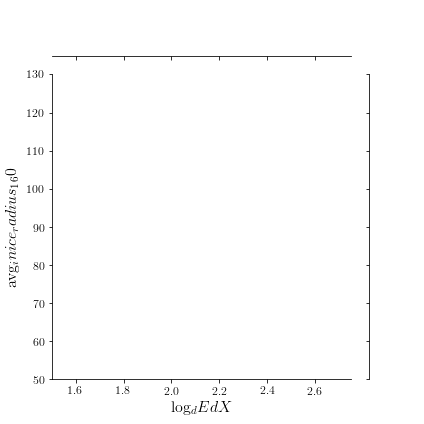

In [12]:
g = sns.JointGrid(x=sim_train_df['log_dEdX'][light_mask & energy_mask],
                  y=sim_train_df['avg_inice_radius_1_60'][light_mask & energy_mask],
                  xlim=(1.5, 2.75), ylim=(100, 160), space=0)


plotting.plot_decision_slice('log_dEdX', 'avg_inice_radius_1_60', sim_train_df[feature_list], pipeline,
                             filler_feature_dict=feature_dict, xres=0.02, yres=0.02, colors=['C0', 'C1'],
                             ax=g.ax_joint)


light_contour = sns.kdeplot(sim_train_df['log_dEdX'][light_mask & energy_mask & zenith_mask],
            sim_train_df['avg_inice_radius_1_60'][light_mask & energy_mask & zenith_mask],
            cmap='Blues', label='light', ax=g.ax_joint)
#             cmap='Blues', label='light', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
dE_dX_bins = np.linspace(1.5, 2.75, 50)
inice_radius_bins = np.linspace(100, 160, 50)
_ = g.ax_marg_x.hist(sim_train_df['log_dEdX'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=dE_dX_bins, label='light')
_ = g.ax_marg_y.hist(sim_train_df['avg_inice_radius_1_60'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=inice_radius_bins, orientation="horizontal")


g.x = sim_train_df['log_dEdX'][heavy_mask & energy_mask]
g.y = sim_train_df['avg_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask]
# g = g.plot_joint(sns.kdeplot, cmap='Oranges', label='heavy')
heavy_contour = sns.kdeplot(sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask],
            sim_train_df['avg_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask],
            cmap='Oranges', label='heavy', ax=g.ax_joint)
#             cmap='Oranges', label='heavy', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
_ = g.ax_marg_x.hist(sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=dE_dX_bins, label='heavy')
_ = g.ax_marg_y.hist(sim_train_df['avg_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=inice_radius_bins, orientation="horizontal")

g.ax_joint.grid()
g.ax_marg_x.grid(axis='x')
g.ax_marg_x.legend(loc='upper center', bbox_to_anchor=(0.85, -0.5),
           frameon=False, ncol=1)
g.ax_marg_y.grid(axis='y')

g.ax_joint.set_xlabel('$\mathrm{\\log_{10}(dE/dX)}$')
g.ax_joint.set_ylabel('$\mathrm{\langle R_{\mu}\\rangle }$')
g.ax_joint.text(1.575, 155, '$\mathrm{ 1.5 < \\log_{10}(S_{125}) \leq 1.75 }$', fontsize=12)
# g.ax_joint.text(1.575, 155, '$\mathrm{ 7.5 < \\log_{10}(E_{reco}/GeV) \leq 7.6 }$', fontsize=12)
g.ax_joint.text(1.575, 151, '$\mathrm{ 0.9 < \cos(\\theta_{reco}) \leq 1.0 }$', fontsize=12)

g.savefig('/home/jbourbeau/public_html/figures/avg_inice_radius-vs-dEdX-contours.png')

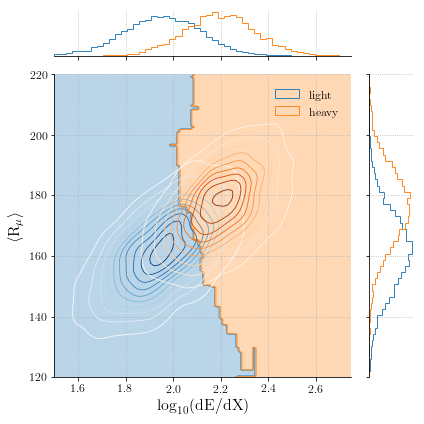

In [17]:
g = sns.JointGrid(x=sim_train_df['log_dEdX'][light_mask & energy_mask],
                  y=sim_train_df['invqweighted_inice_radius_1_60'][light_mask & energy_mask],
                  xlim=(1.5, 2.75), ylim=(120, 220), space=0)


plotting.plot_decision_slice('log_dEdX', 'invqweighted_inice_radius_1_60', sim_train_df[feature_list], pipeline,
                             filler_feature_dict=feature_dict, xres=0.01, yres=0.5, colors=['C0', 'C1'],
                             ax=g.ax_joint)


light_contour = sns.kdeplot(sim_train_df['log_dEdX'][light_mask & energy_mask & zenith_mask],
            sim_train_df['invqweighted_inice_radius_1_60'][light_mask & energy_mask & zenith_mask],
            cmap='Blues', label='light', ax=g.ax_joint)
#             cmap='Blues', label='light', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
dE_dX_bins = np.linspace(1.5, 2.75, 50)
inice_radius_bins = np.linspace(120, 220, 50)
_ = g.ax_marg_x.hist(sim_train_df['log_dEdX'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=dE_dX_bins, label='light')
_ = g.ax_marg_y.hist(sim_train_df['invqweighted_inice_radius_1_60'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=inice_radius_bins, orientation="horizontal")


g.x = sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask]
g.y = sim_train_df['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask]
# g = g.plot_joint(sns.kdeplot, cmap='Oranges', label='heavy')
heavy_contour = sns.kdeplot(sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask],
            sim_train_df['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask],
            cmap='Oranges', label='heavy', ax=g.ax_joint)
#             cmap='Oranges', label='heavy', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
_ = g.ax_marg_x.hist(sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=dE_dX_bins, label='heavy')
_ = g.ax_marg_y.hist(sim_train_df['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=inice_radius_bins, orientation="horizontal")

g.ax_joint.grid()
g.ax_marg_x.grid(axis='x')
g.ax_marg_x.legend(loc='upper center', bbox_to_anchor=(0.85, -0.5),
           frameon=False, ncol=1)
g.ax_marg_y.grid(axis='y')

# g.ax_joint.scatter(sim_train_df['log_dEdX'][light_mask & energy_mask & zenith_mask],
#                    sim_train_df['invqweighted_inice_radius_1_60'][light_mask & energy_mask & zenith_mask],
#                    color='C0', alpha=0.02)
# g.ax_joint.scatter(sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask],
#                    sim_train_df['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask],
#                    color='C1', alpha=0.02)

g.ax_joint.set_xlabel('$\mathrm{\\log_{10}(dE/dX)}$')
g.ax_joint.set_ylabel('$\mathrm{\langle R_{\mu}\\rangle }$')
# g.ax_joint.text(1.575, 155, '$\mathrm{ 1.5 < \\log_{10}(S_{125}) \leq 1.75 }$', fontsize=12)
# # g.ax_joint.text(1.575, 155, '$\mathrm{ 7.5 < \\log_{10}(E_{reco}/GeV) \leq 7.6 }$', fontsize=12)
# g.ax_joint.text(1.575, 151, '$\mathrm{ 0.9 < \cos(\\theta_{reco}) \leq 1.0 }$', fontsize=12)

g.savefig('/home/jbourbeau/public_html/figures/avg_inice_radius-vs-dEdX-contours.png')

In [15]:
feature_dict =  {'avg_inice_radius_1_60': 125, 'lap_cos_zenith': 0.95}

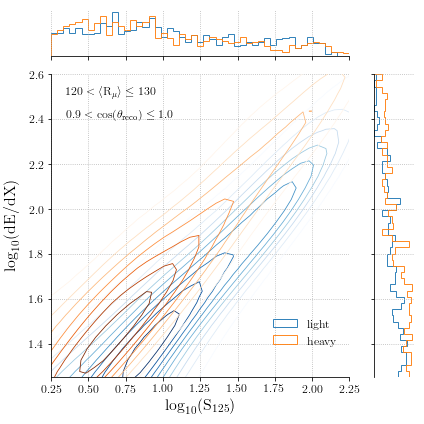

In [16]:
g = sns.JointGrid(y=sim_train_df['log_dEdX'][light_mask & energy_mask],
                  x=sim_train_df['log_s125'][light_mask & energy_mask],
                  ylim=(1.25, 2.6), xlim=(0.25, 2.25), space=0)


# g.ax_joint = plotting.plot_decision_region('log_s125', 'log_dEdX', feature_list, sim_train_df, pipeline,
#                               filler_values_dict=feature_dict, xres=0.02, yres=0.02, ax=g.ax_joint)


light_contour = sns.kdeplot(sim_train_df['log_s125'][light_mask & radius_mask & zenith_mask],
            sim_train_df['log_dEdX'][light_mask & radius_mask & zenith_mask],
            cmap='Blues', label='light', ax=g.ax_joint)

dE_dX_bins = np.linspace(1.25, 2.6, 50)
s125_bins = np.linspace(0.25, 2.25, 50)
_ = g.ax_marg_x.hist(sim_train_df['log_s125'][light_mask & radius_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=s125_bins, label='light')
_ = g.ax_marg_y.hist(sim_train_df['log_dEdX'][light_mask & radius_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=dE_dX_bins, orientation="horizontal")


g.y = sim_train_df['log_dEdX'][heavy_mask & radius_mask]
g.x = sim_train_df['log_s125'][heavy_mask & radius_mask & zenith_mask]
heavy_contour = sns.kdeplot(sim_train_df['log_s125'][heavy_mask & radius_mask & zenith_mask],
            sim_train_df['log_dEdX'][heavy_mask & radius_mask & zenith_mask],
            cmap='Oranges', label='heavy', ax=g.ax_joint)

_ = g.ax_marg_x.hist(sim_train_df['log_s125'][heavy_mask & radius_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=s125_bins, label='heavy')
_ = g.ax_marg_y.hist(sim_train_df['log_dEdX'][heavy_mask & radius_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=dE_dX_bins, orientation="horizontal")

g.ax_joint.grid()
g.ax_marg_x.grid(axis='x')
g.ax_marg_x.legend(loc='upper center', bbox_to_anchor=(0.85, -5.5),
           frameon=False, ncol=1)
g.ax_marg_y.grid(axis='y')

g.ax_joint.set_ylabel('$\mathrm{\\log_{10}(dE/dX)}$')
g.ax_joint.set_xlabel('$\mathrm{\\log_{10}(S_{125})}$')
g.ax_joint.text(0.35, 2.5, '$\mathrm{ 120 < \langle R_{\mu}\\rangle \leq 130 }$', fontsize=12)
g.ax_joint.text(0.35, 2.4, '$\mathrm{ 0.9 < \cos(\\theta_{reco}) \leq 1.0 }$', fontsize=12)

g.savefig('/home/jbourbeau/public_html/figures/dEdX-vs-s125-contours.png')

In [25]:
sim_train_df.log_s125.plot(kind='hist', bins=50)
plt.show()

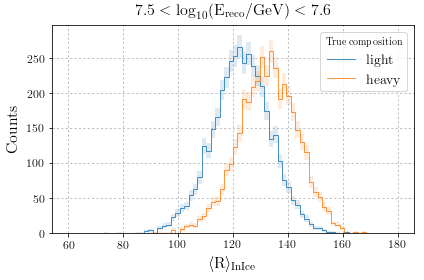

In [18]:
radius_bins = np.linspace(60, 180, 75)

fig, ax = plt.subplots()

# df_sim['log_dEdX'][light_mask & energy_mask].plot(kind='hist', bins=bins, alpha=0.75, label='light', ax=ax)
# df_sim['log_dEdX'][heavy_mask & energy_mask].plot(kind='hist', bins=bins, alpha=0.75, label='heavy', ax=ax)

light_counts = np.histogram(df_sim['avg_inice_radius'][light_mask & energy_mask], radius_bins)[0]
heavy_counts = np.histogram(df_sim['avg_inice_radius'][heavy_mask & energy_mask], radius_bins)[0]

plotting.plot_steps(radius_bins, light_counts, yerr=np.sqrt(light_counts), ax=ax, color='C0', label='light')
plotting.plot_steps(radius_bins, heavy_counts, yerr=np.sqrt(heavy_counts), ax=ax, color='C1', label='heavy')

# ax.set_yscale("log", nonposy='clip')
ax.set_ylabel('Counts')
ax.set_xlabel('$\mathrm{\langle R \\rangle _{InIce}}$')
ax.set_title('$\mathrm{ 7.5 < \\log_{10}(E_{reco}/GeV) < 7.6 }$')
# ax.set_xlim([70, 170])
ax.set_ylim(0)
ax.grid()
ax.legend(title='True composition')
plt.savefig('/home/jbourbeau/public_html/figures/avg-radius-dist-example.png')
plt.show()

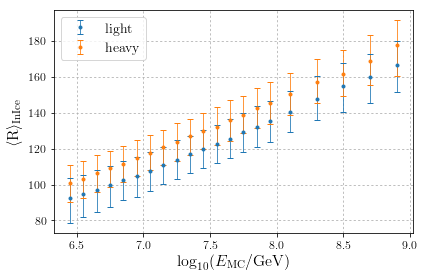

In [19]:
energybins = comp.analysis.get_energybins()
fig, ax = plt.subplots()
light_mask = df_sim['MC_comp_class'] == 'light'
bin_centers, bin_medians_light, error_light = comp.analysis.get_medians(df_sim[light_mask].MC_log_energy.values,
                                                            df_sim[light_mask].avg_inice_radius.values,
                                                            energybins.log_energy_bins)
heavy_mask = df_sim['MC_comp_class'] == 'heavy'
bin_centers, bin_medians_heavy, error_heavy = comp.analysis.get_medians(df_sim[heavy_mask].MC_log_energy.values,
                                                            df_sim[heavy_mask].avg_inice_radius.values,
                                                            energybins.log_energy_bins)

ax.errorbar(bin_centers, bin_medians_light, yerr=error_light, label='light', ls='None', marker='.')
ax.errorbar(bin_centers, bin_medians_heavy, yerr=error_heavy, label='heavy', ls='None', marker='.')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.set_ylabel('$\mathrm{\langle R \\rangle _{InIce}}$')
ax.grid()
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()

s50 = df_sim['log_s50'].values
s50_bins = np.linspace(1, 4, 100)
s50_midpoints = (s50_bins[1:] + s50_bins[:-1]) / 2

light_mask = (df_sim.MC_comp_class == 'light').values
heavy_mask = (df_sim.MC_comp_class == 'heavy').values

light_counts = np.histogram(s50[light_mask], s50_bins)[0]
heavy_counts = np.histogram(s50[heavy_mask], s50_bins)[0]

plotting.plot_steps(s50_midpoints, light_counts, np.sqrt(light_counts), ax, 'C0', 'MC light')
plotting.plot_steps(s50_midpoints, heavy_counts, np.sqrt(heavy_counts), ax, 'C1', 'MC heavy')
ax.set_xlabel('$\mathrm{S}_{50}$')
ax.set_ylabel('Counts')
# ax.set_yscale("log", nonposy='clip')
ax.grid()
ax.legend()
plt.show()

In [ ]:
df_sim.columns.values

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df_sim[df_sim.MC_comp_class == 'light']['lap_s50'],
          df_sim[df_sim.MC_comp_class == 'light']['eloss_1500_standard'],
          label='MC light', alpha=0.5)
ax.scatter(df_sim[df_sim.MC_comp_class == 'heavy']['lap_s50'],
          df_sim[df_sim.MC_comp_class == 'heavy']['eloss_1500_standard'],
          label='MC heavy', alpha=0.5)
plt.show()

In [20]:
df_sim.keys()

Index([u'IceTopMaxSignal', u'IceTopMaxSignalInEdge', u'IceTopMaxSignalString',
       u'IceTopNeighbourMaxSignal', u'IceTopQualityCuts',
       u'IceTop_FractionContainment', u'IceTop_charge', u'IceTop_charge_175m',
       u'InIceQualityCuts', u'InIceQualityCuts_MilliNCascAbove2',
       u'InIceQualityCuts_MilliQtotRatio',
       u'InIceQualityCuts_MilliRloglBelow2',
       u'InIceQualityCuts_NCh_CoincLaputopCleanedPulsesAbove7',
       u'InIceQualityCuts_StochRecoSucceeded', u'InIce_FractionContainment',
       u'InIce_charge_1_60', u'Laputop_IceTop_FractionContainment',
       u'Laputop_InIce_FractionContainment', u'MC_azimuth', u'MC_comp',
       u'MC_comp_class', u'MC_energy', u'MC_type', u'MC_x', u'MC_y',
       u'MC_zenith', u'NChannels_1_60', u'NHits_1_60', u'NStations',
       u'StationDensity', u'angle_MC_Laputop', u'avg_inice_radius',
       u'eloss_1500_standard', u'eloss_1500_strong', u'end_time_mjd',
       u'lap_azimuth', u'lap_beta', u'lap_chi2', u'lap_energy',
       u'

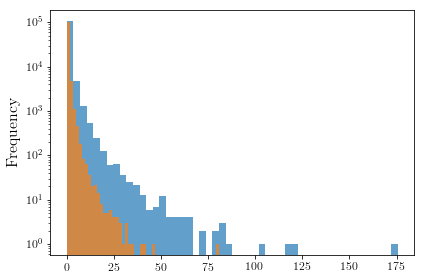

In [21]:
fig, ax = plt.subplots()
light_ratio = df_sim[light_mask].IceTop_charge/df_sim[light_mask].InIce_charge_1_60
light_ratio.plot(kind='hist', bins=50, logy=True, ax=ax, alpha=0.7)
heavy_ratio = df_sim[heavy_mask].IceTop_charge/df_sim[heavy_mask].InIce_charge_1_60
heavy_ratio.plot(kind='hist', bins=50, logy=True, ax=ax, alpha=0.7)
plt.show()

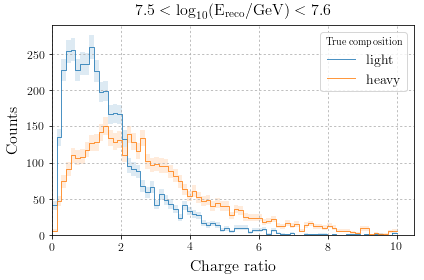

In [32]:
radius_bins = np.linspace(0, 10, 75)

fig, ax = plt.subplots()

ratio = df_sim.InIce_charge_1_60/df_sim.IceTop_charge

light_counts = np.histogram(ratio[light_mask & energy_mask], radius_bins)[0]
heavy_counts = np.histogram(ratio[heavy_mask & energy_mask], radius_bins)[0]

plotting.plot_steps(radius_bins, light_counts, yerr=np.sqrt(light_counts), ax=ax, color='C0', label='light')
plotting.plot_steps(radius_bins, heavy_counts, yerr=np.sqrt(heavy_counts), ax=ax, color='C1', label='heavy')

# ax.set_yscale("log", nonposy='clip')
ax.set_ylabel('Counts')
ax.set_xlabel('Charge ratio')
ax.set_title('$\mathrm{ 7.5 < \\log_{10}(E_{reco}/GeV) < 7.6 }$')
ax.set_xlim(0)
ax.set_ylim(0)
ax.grid()
ax.legend(title='True composition')
# plt.savefig('/home/jbourbeau/public_html/figures/avg-radius-dist-example.png')
plt.show()

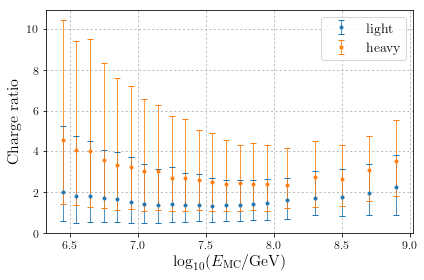

In [34]:
energybins = comp.analysis.get_energybins()
fig, ax = plt.subplots()
ratio = df_sim.InIce_charge_1_60/df_sim.IceTop_charge
light_mask = df_sim['MC_comp_class'] == 'light'
bin_centers, bin_medians_light, error_light = comp.analysis.get_medians(df_sim[light_mask].MC_log_energy.values,
                                                            ratio[light_mask].values,
                                                            energybins.log_energy_bins)
heavy_mask = df_sim['MC_comp_class'] == 'heavy'
bin_centers, bin_medians_heavy, error_heavy = comp.analysis.get_medians(df_sim[heavy_mask].MC_log_energy.values,
                                                            ratio[heavy_mask].values,
                                                            energybins.log_energy_bins)

ax.errorbar(bin_centers, bin_medians_light, yerr=error_light, label='light', ls='None', marker='.')
ax.errorbar(bin_centers, bin_medians_heavy, yerr=error_heavy, label='heavy', ls='None', marker='.')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.set_ylabel('Charge ratio')
ax.grid()
ax.legend()
plt.show()